In [3]:
import pandas as pd
import pickle
import numpy as np

p = r'../data/Hate_speech_labeled_data.csv'
df = pd.read_csv(p)
print(df.shape)
df = df[['class', 'tweet']]
print(df.shape)
print(df['class'].value_counts())

ratio = 0.7
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df_train = df.iloc[:int(ratio * len(df))]
print(df_train.shape)
print(df_train['class'].value_counts())

df_test = df.iloc[int(ratio * len(df)):]
print(df_test.shape)
print(df_test['class'].value_counts())

df_train.to_csv(r'../data/Hate_speech_labeled_data-train.csv', index=False)
df_test.to_csv(r'../data/Hate_speech_labeled_data-test.csv', index=False)
df_train.head()

(24783, 7)
(24783, 2)
1    19190
2     4163
0     1430
Name: class, dtype: int64
(17348, 2)
1    13472
2     2872
0     1004
Name: class, dtype: int64
(7435, 2)
1    5718
2    1291
0     426
Name: class, dtype: int64


,class,tweet
0,1,Pumpkin spice Marlboro's for da hoes
1,1,&#8220;@_CiaraaaS: What things do you love? &#...
2,2,Yankees should have NEVER gave away Melky. Guy...
3,1,@Im_Thirst I love Louis CK! Quit bein a faggot...
4,1,My boyfriend is such a smart ass bitch watch y...


In [4]:
from collections import Counter
from nltk.corpus import stopwords
import re


def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val, vocab=19998):
    word_list = []

    print("create vocab")
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        sent = sent.replace(r"<br />",' ')
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    print("sorting")
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:vocab]
    # creating a dict
    onehot_dict = {w:i+1 for i, w in enumerate(corpus_)}

    print('tokenizing')
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = y_train
    encoded_test = y_val

    return final_list_train, encoded_train, final_list_test, encoded_test,onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize(x_train=df_train['tweet'],
                                               y_train=df_train['class'],
                                               x_val=df_test['tweet'],
                                               y_val=df_test['class'])
print(y_train.value_counts())
print(y_test.value_counts())

create vocab
sorting
tokenizing
1    13472
2     2872
0     1004
Name: class, dtype: int64
1    5718
2    1291
0     426
Name: class, dtype: int64


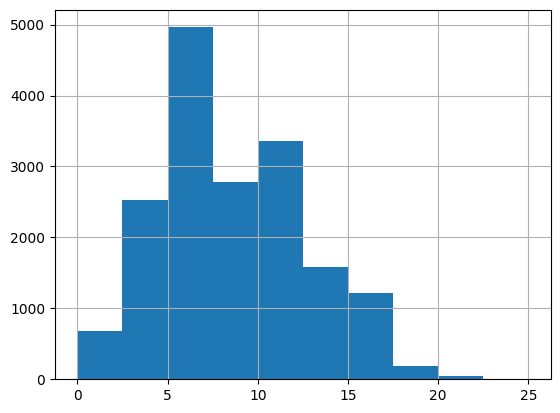

count    17348.000000
mean         8.372435
std          4.009132
min          0.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         25.000000
dtype: float64

In [5]:
import matplotlib.pyplot as plt

rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [6]:
max_len = 25

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding_(x_train,max_len)
x_test_pad = padding_(x_test,max_len)
print(len(x_train_pad), len(y_train))
print(len(x_test_pad), len(y_test))
print(len(x_train_pad[0]))

17348 17348
7435 7435
25


In [7]:
train_tokenized_idx = np.array(x_train_pad)
train_labels_np = np.array(y_train)
train_data = (train_tokenized_idx, train_labels_np)
print(train_tokenized_idx.shape)
print(train_labels_np.shape)

print('now dumping pickle')
with open(file='Hate_speech_labeled_data-train.pkl', mode='wb') as f:
    pickle.dump(train_data, f)

(17348, 25)
(17348,)
now dumping pickle


In [8]:
test_tokenized_idx = np.array(x_test_pad)
test_labels_np = np.array(y_test)
test_data = (test_tokenized_idx, test_labels_np)
print(test_tokenized_idx.shape)
print(test_labels_np.shape)

print('now dumping test pickle')
# with open(file='ag_test.pkl', mode='wb') as f:
with open(file='Hate_speech_labeled_data-test.pkl', mode='wb') as f:
    pickle.dump(test_data, f)

(7435, 25)
(7435,)
now dumping test pickle
